In [1]:
import numpy as np
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# plate Model Inference

In [2]:
plate_model = YOLO('runs plate detection\detect\\train\weights\\best.pt')

In [3]:
def plate_prediction(path, box):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    rect = cv.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,250,0), 2)
    
    return rect
    
def crop_image(path, box):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    dims = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
    cropped_image = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]

    plt.imshow(cropped_image)
    
    return cropped_image

source = 'tests\\Cars409.png'
results = plate_model.predict(source)
boxes = results[0].boxes
box = boxes.xyxy[0].cpu().numpy()
plate_prediction(source, box)


image 1/1 d:\projects\CV\plate car detection and recongnition\tests\Cars409.png: 576x640 1 plate, 410.1ms
Speed: 9.9ms preprocess, 410.1ms inference, 13.5ms postprocess per image at shape (1, 3, 576, 640)


array([[[63, 63, 63],
        [65, 65, 65],
        [65, 65, 65],
        ...,
        [64, 62, 63],
        [64, 62, 63],
        [64, 62, 63]],

       [[64, 64, 64],
        [64, 64, 64],
        [64, 64, 64],
        ...,
        [65, 63, 64],
        [65, 63, 64],
        [66, 64, 65]],

       [[64, 64, 64],
        [64, 64, 64],
        [64, 64, 64],
        ...,
        [65, 65, 65],
        [66, 64, 65],
        [67, 65, 66]],

       ...,

       [[63, 63, 63],
        [65, 65, 65],
        [65, 65, 65],
        ...,
        [66, 66, 66],
        [67, 67, 67],
        [65, 65, 65]],

       [[63, 63, 63],
        [64, 64, 64],
        [65, 65, 65],
        ...,
        [65, 65, 65],
        [64, 64, 64],
        [66, 66, 66]],

       [[63, 63, 63],
        [64, 64, 64],
        [63, 63, 63],
        ...,
        [65, 65, 65],
        [66, 66, 66],
        [66, 66, 66]]], dtype=uint8)

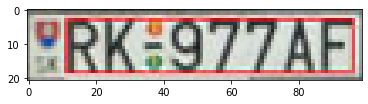

In [4]:
cropped = crop_image(source, box)

# Character Model Inference

In [5]:
character_model = YOLO('runs characters recognition\\detect\\train4\\weights\\best.pt')

In [6]:
def characters_prediction(path, boxes, clss):
    if '/' in path:
        img = cv.imread(path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    else:
        img = cv.cvtColor(path, cv.COLOR_BGR2RGB)
    classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","1","2","3","4","5","6","7","8","9","0"]
    txt = []
    for box, cls in zip(boxes, clss):
        x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        rect = cv.rectangle(img, (x1, y1), (x2, y2), (0, 250, 0), 1)
        class_name = classes[cls]
        txt.append((x1, class_name))
        text_size, _ = cv.getTextSize(class_name, cv.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        text_x = max(x1, 0)
        text_y = max(y1 - 10, 0)
        cv.rectangle(img, (text_x, text_y), (text_x + text_size[0], text_y - text_size[1]), (0, 250, 0), cv.FILLED)
        cv.putText(img, class_name, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    sorted_data = sorted(txt, key=lambda x: x[0])
    data = ""
    for i in sorted_data:
        data += i[1]
    
    return data, rect

source = cropped
results = character_model.predict(source)
boxes = results[0].boxes
clss =list(map(int, boxes.cls.cpu().numpy()))
boxes = boxes.xyxy.cpu().numpy()
characters_prediction(source, boxes, clss);


0: 160x640 1 A, 1 K, 1 R, 2 7s, 1 9, 155.0ms
Speed: 2.0ms preprocess, 155.0ms inference, 2.0ms postprocess per image at shape (1, 3, 160, 640)


# Real Time Prediction

In [10]:

video_path = "video\\4.mp4"
cap = cv.VideoCapture(video_path)

def crop_image(img, box):
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    dims = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
    cropped_image = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
    
    return cropped_image

width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv.CAP_PROP_FPS)

# Define the codec and create a VideoWriter object
output_path = "prediction_video.mp4"
fourcc = cv.VideoWriter_fourcc(*"MP4V")  # Specify the codec (e.g., "mp4v" for MP4 format)
out = cv.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    success, frame = cap.read()

    if success:
        results = plate_model(frame)
        boxes = results[0].boxes
        box = boxes.xyxy[0].cpu().numpy()
        cropped = crop_image(frame, box)
        results = character_model(cropped)
        boxes = results[0].boxes
        clss =list(map(int, boxes.cls.cpu().numpy()))
        boxes = boxes.xyxy.cpu().numpy()
        data, rect = characters_prediction(cropped, boxes, clss)
        frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = rect
        x, y = int(box[0]), int(box[1]) 
        text_x, text_y, w, h = x, y - 10, int(box[2])-int(box[0]), int(box[3])-int(box[1])
        cv.rectangle(frame, (text_x-10, text_y - (10+20)), (text_x+10 + w, text_y+10), (0, 0, 0), cv.FILLED)
        cv.putText(frame, data, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2, cv.LINE_AA)

        cv.imshow("YOLOv8 Inference", frame)

        out.write(frame)

        if cv.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        break

cap.release()
cv.destroyAllWindows()

0: 384x640 1 plate, 1480.0ms
Speed: 131.9ms preprocess, 1480.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 192x640 1 D, 1 K, 1 R, 1 1, 1 2, 2 7s, 177.0ms
Speed: 4.0ms preprocess, 177.0ms inference, 3.0ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 1 plate, 204.9ms
Speed: 6.0ms preprocess, 204.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 192x640 1 D, 1 K, 1 R, 1 1, 1 2, 2 7s, 170.0ms
Speed: 4.0ms preprocess, 170.0ms inference, 5.0ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 1 plate, 600.0ms
Speed: 3.0ms preprocess, 600.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 192x640 1 D, 1 K, 1 R, 1 1, 1 2, 2 7s, 122.0ms
Speed: 3.0ms preprocess, 122.0ms inference, 3.0ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 1 plate, 203.0ms
Speed: 4.0ms preprocess, 203.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 192x640 1 D, 1 K, 1 R, 1 1, 1 2, 2 7s,